In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sys
import warnings
import tqdm
sys.path.append('..')

C:\Users\applepy\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import xgboost as xgb
import yaml
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, roc_auc_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
import optuna
from functools import partial
import scipy.spatial.distance as ssd
from sklearn.decomposition import PCA

In [3]:
import src.dax_utils as utils

In [4]:
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('bmh')
warnings.filterwarnings("ignore")

In [5]:
import importlib
importlib.reload(utils)

<module 'src.dax_utils' from 'E:\\working\\pet-project\\investment-2024\\daxex\\_repo\\dax-24-strat\\proof_of_concept\\..\\src\\dax_utils.py'>

### Constants

In [6]:
FEATURE_SELECTION_AUC_DROP_THRESHOLD = .05

### Read in artifacts

In [7]:
X_train = pd.read_csv('dataset/X_train.csv', index_col=0, parse_dates=[0])
y_train = pd.read_csv('dataset/y_train.csv', index_col=0, parse_dates=[0])
X_test = pd.read_csv('dataset/X_test.csv', index_col=0, parse_dates=[0])
y_test = pd.read_csv('dataset/y_test.csv', index_col=0, parse_dates=[0])

### Baseline model

In [8]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [9]:
y_prob = xgb_model.predict_proba(X_test)
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

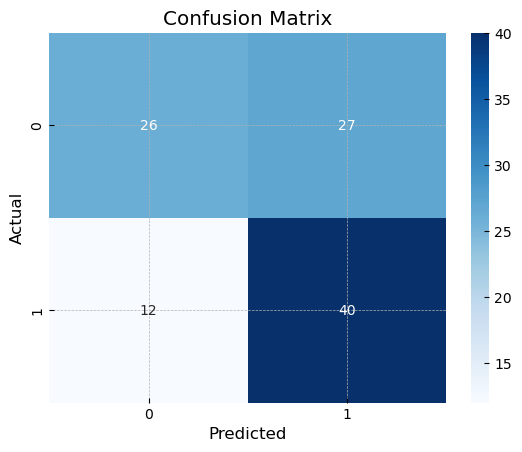

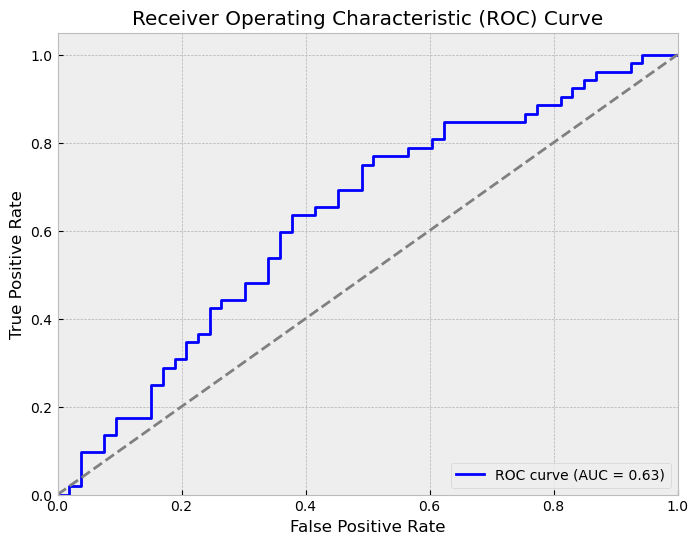

              precision    recall  f1-score   support

           0       0.68      0.49      0.57        53
           1       0.60      0.77      0.67        52

    accuracy                           0.63       105
   macro avg       0.64      0.63      0.62       105
weighted avg       0.64      0.63      0.62       105



In [10]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

### Feature Selection

In [11]:
X_sm_train = sm.add_constant(X_train)
model = sm.Logit(y_train, X_sm_train)
results = model.fit()

         Current function value: 1.714336
         Iterations: 35


In [12]:
number_of_significant_features = (results.pvalues < .05).sum() # 42

In [13]:
number_of_significant_features

42

In [14]:
results.pvalues[results.pvalues < .05].sort_values().head(15)

sunrise_dusk            0.00
low_bnd_avglow_vol5d    0.00
close_bnd               0.00
close_ief close_gdaxi   0.00
close_bnd close_gdaxi   0.00
close_bnd close_ief     0.00
low_ief_avglow_vol5d    0.00
anomaly                 0.00
close_bnd_avgvol5d      0.00
close_bnd_day1          0.00
close_ief_day1          0.00
low_bnd_day7            0.00
low_gld_avglow_vol5d    0.00
close_spy_day1          0.00
open_spy                0.00
dtype: float64

In [15]:
tree_based_feature_importances = utils.Tools.get_tree_model_feature_importances(xgb_model, X_train.columns)

In [16]:
tree_based_feature_importances.head(15)

savgol_close_gdaxi_w10_p3    0.03
non_business_days_in_month   0.02
low_spy_avglow_vol5d         0.02
business_days_in_month       0.01
year_days_left               0.01
month_first_day              0.01
close_ief_avgspy_corr30d     0.01
close_gdaxi_kmomentum        0.01
close_ief_avgspy_corr10d     0.01
sunrise_dusk                 0.01
savgol_close_gdaxi_w10_p2    0.01
year_days_passed             0.01
close_bnd close_gdaxi        0.01
close_ief_avggdaxi_corr10d   0.01
close_bnd_avggdaxi_corr10d   0.01
dtype: float32

### Recurise Feature Elimination with Custom TimeSeriesSplit

In [17]:
# baseline_score = roc_auc_score(y_test, y_prob[:,1])
# baseline_score

In [19]:
scores = list()
timeseries_splitter = utils.ReasonableTimeSeriesSplit(n_splits=3)

for train_index, test_index in timeseries_splitter.split(X_train):
    # print("TRAIN:", len(train_index), "TEST:", len(test_index))
    xgb_model = xgb.XGBClassifier(random_state=42)
    xgb_model.fit(X_train.iloc[train_index,:], y_train.iloc[train_index])
    
    scores.append(
        roc_auc_score(y_train.iloc[test_index], xgb_model.predict_proba(X_train.iloc[test_index,:])[:,1])
    )

In [20]:
baseline_score = np.array(scores).mean()
baseline_score

0.6251646232349765

In [21]:
import importlib
importlib.reload(utils)

<module 'src.dax_utils' from 'E:\\working\\pet-project\\investment-2024\\daxex\\_repo\\dax-24-strat\\proof_of_concept\\..\\src\\dax_utils.py'>

In [51]:
# del RFE_FEATURES; del _RFE_FEATURES

In [52]:
big_step, small_step = 10, 5
timeseries_splitter = utils.ReasonableTimeSeriesSplit(n_splits=6)
number_of_features = X_train.columns.shape[0] - big_step
step = big_step
current_score = baseline_score
all_scores = {}

progress_bar = tqdm.tqdm(total=number_of_features, desc="Processing")

n = 0
while current_score > (baseline_score - FEATURE_SELECTION_AUC_DROP_THRESHOLD) and number_of_features > 0:
    try:
        RFE_FEATURES = _RFE_FEATURES.copy()
    except NameError:
        RFE_FEATURES = X_train.columns
    
    rfe = RFE(estimator=xgb_model, n_features_to_select=number_of_features)
    rfe.fit(X_train[RFE_FEATURES], y_train)
    
    _RFE_FEATURES = X_train[RFE_FEATURES].columns[rfe.support_]
    
    scores = list()
    for train_index, test_index in timeseries_splitter.split(X_train):
        # print("TRAIN:", len(train_index), "TEST:", len(test_index))
        xgb_model = xgb.XGBClassifier(random_state=42)
        xgb_model.fit(X_train.iloc[train_index,:].loc[:,_RFE_FEATURES], y_train.iloc[train_index])

        scores.append(
            roc_auc_score(y_train.iloc[test_index], xgb_model.predict_proba(X_train.iloc[test_index,:].loc[:,_RFE_FEATURES])[:,1])
        )

    current_score = np.array(scores).mean()
    all_scores[number_of_features] = scores.copy()
    
    if n % 5 == 0:
        FEATURE_SELECTION_AUC_DROP_THRESHOLD = FEATURE_SELECTION_AUC_DROP_THRESHOLD - .01
        step = step - 1
        
    number_of_features = number_of_features - step
    progress_bar.set_description(f"Processing (AUC: {current_score:.4f})")
    progress_bar.update(step)
    n += 1

progress_bar.close()

Processing (AUC: 0.6252):  73%|███████████████████████████████████████▌              | 179/244 [04:15<01:32,  1.43s/it]


In [53]:
RFE_FEATURES

Index(['low_ief', 'high_spy', 'close_gdaxi', 'low_ief_day1', 'low_gdaxi_day1',
       'volume_gld_day1', 'volume_spy_day1', 'close_spy_day1', 'low_gld_day3',
       'open_bnd_day3', 'close_ief_day3', 'high_gdaxi_day7', 'open_bnd_day7',
       'close_bnd_day7', 'close_ief_day7', 'open_bnd_day20',
       'open_gdaxi_day20', 'volume_bnd_day20', 'volume_ief_day20',
       'close_gdaxi_day20', 'year_days_passed', 'year_days_left',
       'month_first_day', 'last_friday', 'sunrise_dusk',
       'business_days_in_month', 'non_business_days_in_month',
       'close_gdaxi_kmomentum', 'bnd_stochastic_oscillator',
       'gdaxi_stochastic_oscillator', 'close_gld_avgvol5d',
       'close_ief_avgvol3d', 'close_spy_avgvol5d', 'close_gdaxi_avgvol3d',
       'close_gdaxi_avgvol5d', 'high_bnd_avghigh_vol5d',
       'high_gld_avghigh_vol3d', 'high_gld_avghigh_vol5d',
       'high_ief_avghigh_vol5d', 'high_spy_avghigh_vol3d',
       'high_spy_avghigh_vol5d', 'high_gdaxi_avghigh_vol3d',
       'high_gdaxi

### Test Reduced Feature Set

In [54]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train[RFE_FEATURES], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [55]:
y_prob = xgb_model.predict_proba(X_test[RFE_FEATURES])
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

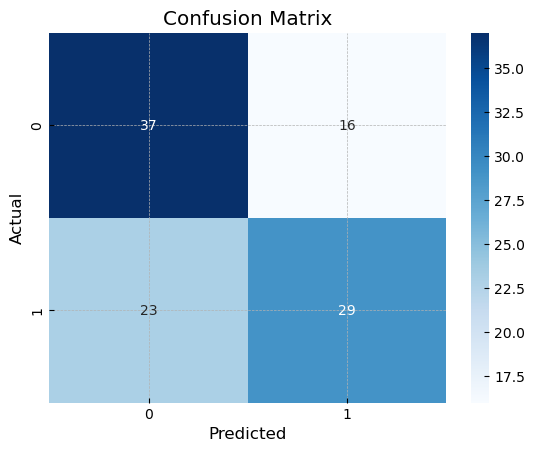

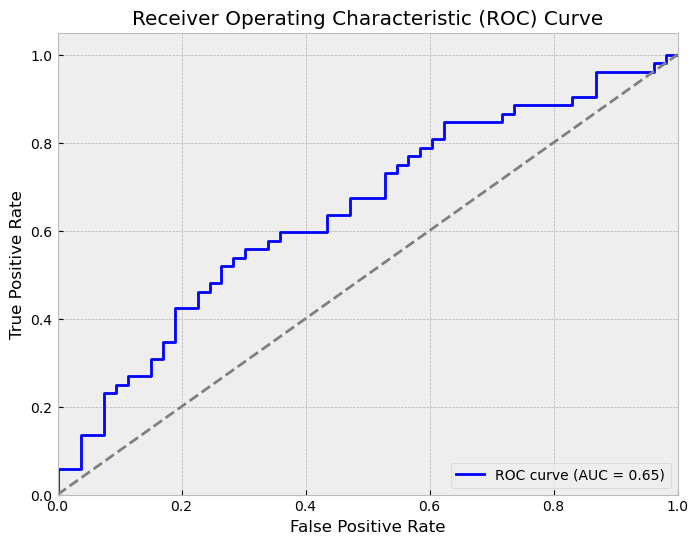

              precision    recall  f1-score   support

           0       0.62      0.70      0.65        53
           1       0.64      0.56      0.60        52

    accuracy                           0.63       105
   macro avg       0.63      0.63      0.63       105
weighted avg       0.63      0.63      0.63       105



In [56]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

### Hyperparam optimization

In [57]:
def objective_xgboost_classification(X_train, y_train, trial):

    _X_train, X_valid = X_train[:int(X_train.shape[0] * .7)], X_train[int(X_train.shape[0] * .7):]
    _y_train, y_valid = y_train[:int(X_train.shape[0] * .7)], y_train[int(X_train.shape[0] * .7):]

    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 900, 1100),
        'max_depth': trial.suggest_int('max_depth', 8, 18),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e-1),
        'min_child_weight': trial.suggest_int('min_child_weight', 6, 9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e-1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1e-1),
        'use_label_encoder': False,
        'eval_metric': 'auc',
        'verbose' : -1
    }

    
    # Initialize the XGBoost classifier model with hyperparameters
    model = xgb.XGBClassifier(**params, random_state=42)
    
    # Train the model
    model.fit(_X_train, _y_train)
    
    # Evaluate the model on the validation set using AUC
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, y_pred_proba)
    # score = recall_score(y_valid, y_pred_proba)
    
    return score 

In [58]:
# Define the study and optimize hyperparameters
study_xgboost_classification = optuna.create_study(direction='maximize')
objective = partial(objective_xgboost_classification, X_train.loc[:,RFE_FEATURES], y_train)
study_xgboost_classification.optimize(objective, n_trials=100)

[I 2024-06-22 13:23:42,424] A new study created in memory with name: no-name-4d1bc229-93ff-4135-9647-ce9bdfad0b3a
[I 2024-06-22 13:23:44,463] Trial 0 finished with value: 0.6278291132551223 and parameters: {'n_estimators': 918, 'max_depth': 10, 'learning_rate': 0.057387196771117636, 'subsample': 0.6250712634177197, 'colsample_bytree': 0.9922769776404405, 'gamma': 0.08400491616562325, 'min_child_weight': 6, 'reg_alpha': 0.009791816626128505, 'reg_lambda': 0.0954449979806799}. Best is trial 0 with value: 0.6278291132551223.
[I 2024-06-22 13:23:52,383] Trial 1 finished with value: 0.6282933973516933 and parameters: {'n_estimators': 1099, 'max_depth': 16, 'learning_rate': 0.001938606125598425, 'subsample': 0.9496175569269076, 'colsample_bytree': 0.864690191062201, 'gamma': 0.04525665010152099, 'min_child_weight': 7, 'reg_alpha': 0.06341243557453974, 'reg_lambda': 0.059821926831147974}. Best is trial 1 with value: 0.6282933973516933.
[I 2024-06-22 13:23:55,267] Trial 2 finished with value: 

[I 2024-06-22 13:24:43,315] Trial 20 finished with value: 0.6331740423668674 and parameters: {'n_estimators': 946, 'max_depth': 17, 'learning_rate': 0.08224465881768163, 'subsample': 0.9109031876247856, 'colsample_bytree': 0.8390632537432207, 'gamma': 0.018809651192098795, 'min_child_weight': 9, 'reg_alpha': 0.044222695916157274, 'reg_lambda': 0.03534071497541907}. Best is trial 18 with value: 0.6374771632619167.
[I 2024-06-22 13:24:45,543] Trial 21 finished with value: 0.6190643354320485 and parameters: {'n_estimators': 962, 'max_depth': 17, 'learning_rate': 0.056140776231450966, 'subsample': 0.9915630488242422, 'colsample_bytree': 0.890247119807501, 'gamma': 0.00927654658417007, 'min_child_weight': 8, 'reg_alpha': 0.02379474596266045, 'reg_lambda': 0.028889488312585268}. Best is trial 18 with value: 0.6374771632619167.
[I 2024-06-22 13:24:47,784] Trial 22 finished with value: 0.6300335190469719 and parameters: {'n_estimators': 992, 'max_depth': 15, 'learning_rate': 0.0488258319389238

[I 2024-06-22 13:25:34,854] Trial 40 finished with value: 0.622185985414685 and parameters: {'n_estimators': 910, 'max_depth': 16, 'learning_rate': 0.024772409349080312, 'subsample': 0.573856367580781, 'colsample_bytree': 0.8191351436492758, 'gamma': 0.0309981258615349, 'min_child_weight': 9, 'reg_alpha': 0.05744458292558097, 'reg_lambda': 0.049065437001481076}. Best is trial 26 with value: 0.6426144856638131.
[I 2024-06-22 13:25:38,478] Trial 41 finished with value: 0.6367260044390088 and parameters: {'n_estimators': 929, 'max_depth': 14, 'learning_rate': 0.008757715232143574, 'subsample': 0.6874549931721797, 'colsample_bytree': 0.8358368694364029, 'gamma': 0.05460112751122632, 'min_child_weight': 9, 'reg_alpha': 0.04719480590089242, 'reg_lambda': 0.06549733168824168}. Best is trial 26 with value: 0.6426144856638131.
[I 2024-06-22 13:25:41,601] Trial 42 finished with value: 0.6301769564101403 and parameters: {'n_estimators': 930, 'max_depth': 12, 'learning_rate': 0.014473449077979709,

[I 2024-06-22 13:26:40,747] Trial 60 finished with value: 0.6268326010478478 and parameters: {'n_estimators': 967, 'max_depth': 9, 'learning_rate': 0.00037973949898774395, 'subsample': 0.6071094846220211, 'colsample_bytree': 0.826167676168733, 'gamma': 0.0058458712221028195, 'min_child_weight': 7, 'reg_alpha': 0.06968009168033974, 'reg_lambda': 0.09498689399902968}. Best is trial 26 with value: 0.6426144856638131.
[I 2024-06-22 13:26:43,212] Trial 61 finished with value: 0.6284670320544761 and parameters: {'n_estimators': 931, 'max_depth': 8, 'learning_rate': 0.01537515084971967, 'subsample': 0.6271196334818616, 'colsample_bytree': 0.8145815594590979, 'gamma': 0.02010491156722506, 'min_child_weight': 9, 'reg_alpha': 0.05941034176846484, 'reg_lambda': 0.05847389265765645}. Best is trial 26 with value: 0.6426144856638131.
[I 2024-06-22 13:26:46,276] Trial 62 finished with value: 0.6335817064516617 and parameters: {'n_estimators': 941, 'max_depth': 9, 'learning_rate': 0.010640410251379502

[I 2024-06-22 13:27:43,817] Trial 80 finished with value: 0.6139270130301521 and parameters: {'n_estimators': 907, 'max_depth': 15, 'learning_rate': 0.07400648062374665, 'subsample': 0.540985871962835, 'colsample_bytree': 0.8534171549326826, 'gamma': 0.023795790858214313, 'min_child_weight': 8, 'reg_alpha': 0.0637801928005213, 'reg_lambda': 0.023353934025443605}. Best is trial 26 with value: 0.6426144856638131.
[I 2024-06-22 13:27:47,716] Trial 81 finished with value: 0.6377527139858978 and parameters: {'n_estimators': 928, 'max_depth': 15, 'learning_rate': 0.008795571323293715, 'subsample': 0.7556701311907558, 'colsample_bytree': 0.8733249390991588, 'gamma': 0.06551847505839001, 'min_child_weight': 9, 'reg_alpha': 0.04720329001070295, 'reg_lambda': 0.03172137820418945}. Best is trial 26 with value: 0.6426144856638131.
[I 2024-06-22 13:27:51,609] Trial 82 finished with value: 0.6335628331144026 and parameters: {'n_estimators': 940, 'max_depth': 15, 'learning_rate': 0.009788743193788566

In [59]:
best_params = study_xgboost_classification.best_params
best_auc = study_xgboost_classification.best_value

print("Best AUC:", best_auc)
print("Best Hyperparameters:", best_params)

Best AUC: 0.6426144856638131
Best Hyperparameters: {'n_estimators': 929, 'max_depth': 16, 'learning_rate': 0.06194041983470603, 'subsample': 0.8677011457932563, 'colsample_bytree': 0.9560105522288573, 'gamma': 0.009593160373648145, 'min_child_weight': 7, 'reg_alpha': 0.051981159358160355, 'reg_lambda': 0.02325862061994719}


Best parameters

In [65]:
xgb_model = xgb.XGBClassifier(**best_params, random_state=42)
xgb_model.fit(X_train[RFE_FEATURES], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9560105522288573, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.009593160373648145,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06194041983470603,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=929, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [66]:
y_prob = xgb_model.predict_proba(X_test[RFE_FEATURES])
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

In [69]:
os.makedirs('../config', exist_ok=True)

config = {
    'selected_features' : list(RFE_FEATURES),
    'threshold' : float(optimal_threshold[0]),
    'xgb_classifier_params' : best_params
}

with open('../config/config.yaml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

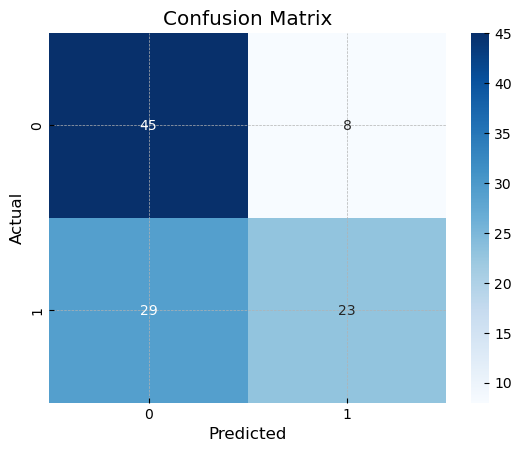

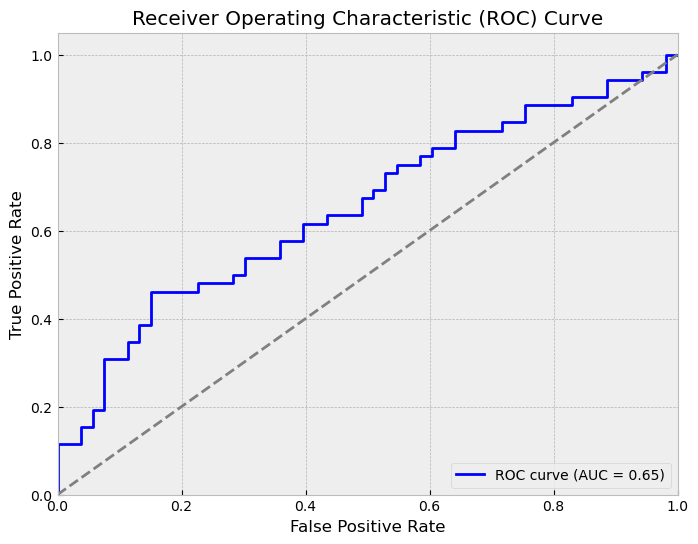

              precision    recall  f1-score   support

           0       0.61      0.85      0.71        53
           1       0.74      0.44      0.55        52

    accuracy                           0.65       105
   macro avg       0.68      0.65      0.63       105
weighted avg       0.67      0.65      0.63       105



In [67]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)